In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
#%matplotlib inline
from matplotlib import colors
from IPython import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout

import tensorflow as tf
from poisson import *
from fun1d import *


In [ ]:
n = 2**10
m = 2
l = 0.01
pi = math.pi
max_err = 1e-8
max_epoch = 1
epsilon = 1e-4
optim_pars = [max_err, max_epoch]

# define filters
sigma = determine_sigma(epsilon)
Q = 1
alpha = 2
# J = determine_J(n, Q, sigma, alpha)
J = 7
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
# xi = np.arange(1,3) * pi / 3
nxi = 2
xi = np.random.choice(n, nxi) * pi / n
g, g_hat = gabor_wave_family_1d(n, s, xi, sigma)

n_wave = g_hat.shape[1]*g_hat.shape[2]

x_dim = n
ndata = 60000

sx_dim = 1 + n_wave + n_wave**2 # zero + 1st + 2nd order
t = np.linspace(0, x_dim + 1, x_dim + 1)
mu = 1
x_data = np.zeros((ndata, x_dim))
sx_data = np.zeros((ndata, sx_dim))
y_data = np.zeros((ndata, 10))

for i in range(ndata):
    j = np.random.choice(10,1)
    lamb = l * (j + 1)
    x = sample_compound_poisson(t, lamb,'const',mu)
    x_data[i,:] = np.diff(x)
    sx = scat_infreq_1d(x_data[i,:], g_hat, m)
    sx_data[i,:] = np.asarray([sx[0]] + list(sx[1]) + list(sx[2].flatten()))
    y_data[i,j] = 1
np.save('x_data', x_data)
np.save('sx_data', sx_data)
np.save('y_data', y_data)
# x_data = np.load('x_data.npy')
# sx_data = np.load('sx_data.npy')


In [3]:
class dcgan(object):
    def __init__(self, sess, x_dim, y_dim, x_data, y_data, batch_size = 64, nepoch = 20, \
                z_dim = 100, gf_dim = 64, df_dim = 64, lr = 1e-3):
    
        self.sess = sess
        self.batch_size = batch_size
        self.nepoch = nepoch
        self.lr = lr
        
        self.z_dim = z_dim
        
        self.x_dim = x_dim
        self.y_dim = y_dim

        self.gf_dim = 64
        self.df_dim = 64
        
        self.x_data = x_data
        self.y_data = y_data
        
        self.nbatch = len(self.x_data) // self.batch_size
        self.gf_dim = gf_dim
        self.df_dim = df_dim
        self.d_loss_real_avg = []
        self.d_loss_fake_avg = []
        self.g_loss_avg = []
        self.d_loss_avg = []
        self.build_model()
        
    def build_model(self):
        self.inputs = tf.placeholder(tf.float32, [self.batch_size, self.x_dim])
        self.y = tf.placeholder(tf.float32, [self.batch_size, self.y_dim])
        self.z = tf.placeholder(tf.float32, [self.batch_size, self.z_dim])
        self.keep_prob = tf.placeholder(tf.float32)
        
        self.G = self.generator(self.z, self.y, self.keep_prob) # fake data
        self.D = self.discriminator(self.inputs, self.y, self.keep_prob) # prob of true data
        self.D_ = self.discriminator(self.G, self.y, self.keep_prob, reuse = True) # prob of fake data
        
        def sigmoid_cross_entropy_with_logits(x, y):
            return tf.nn.sigmoid_cross_entropy_with_logits(logits = x, labels = y)
        
        self.d_real_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D, tf.ones_like(self.D)))
        self.d_fake_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D_, tf.zeros_like(self.D)))
        self.g_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D_, tf.ones_like(self.D_)))
        
        self.d_loss = self.d_real_loss + self.d_fake_loss
        
        
    def train(self):
        d_optim = tf.train.AdamOptimizer(self.lr).minimize(self.d_loss)
        g_optim = tf.train.AdamOptimizer(self.lr).minimize(self.g_loss)
        
        init = tf.global_variables_initializer() # initialize
        self.sess.run(init)
#         sample_z = np.random.uniform(-1, 1, size=(self.sample_num , self.z_dim))
#         sample_inputs = self.x_data[0:self.sample_num]
#         sample_sx = self.sx_data[0:self.sample_num]
        saver = tf.train.Saver()
    
        for epoch in range(self.nepoch):
            for idx in range(self.nbatch):
                batch_inputs = self.x_data[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_y = self.y_data[idx*self.batch_size:(idx+1)*self.batch_size]
                
                batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)
                
                for i in range(5):
                    _, errD = self.sess.run([d_optim, self.d_loss], feed_dict = {
                        self.inputs: batch_inputs,
                        self.y: batch_y,
                        self.z: batch_z,
                        self.keep_prob: 0.7
                    })
                
                _, errG = self.sess.run([g_optim, self.g_loss], feed_dict = {
                    self.y: batch_y,
                    self.z: batch_z,
                    self.keep_prob: 0.7
                })
                
                errD_fake = self.d_fake_loss.eval({
                    self.z: batch_z, 
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                errD_real = self.d_real_loss.eval({
                    self.inputs: batch_inputs,
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                errG = self.g_loss.eval({
                    self.z: batch_z,
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                
                self.d_loss_fake_avg.append(errD_fake)
                self.d_loss_real_avg.append(errD_real)
                self.g_loss_avg.append(errG)
                self.d_loss_avg.append(errD_fake + errD_real)
                
                if idx % 20 == 0:
                    self.plot_dist(idx)
                    print("Epoch: %2d, Iter: %2d, d_loss: %.8f, g_loss:%.8f" % (epoch, idx, errD, errG))
#                     saver.save(self.sess, 'gan_syn.ckpt')
                    
    def plot_dist(self,idx):
        fig = plt.figure(figsize = (10,7))
        font = {'size':20}
        ax1 = fig.add_subplot(212)
        sample_z = np.random.uniform(-1, 1, [self.batch_size , self.z_dim]).astype(np.float32)
        sample_y = self.y_data[idx*self.batch_size:(idx + 1)*self.batch_size]
        
        sample = self.G.eval({
                    self.z: sample_z,
                    self.y: sample_y,
                    self.keep_prob: 1.0
                })
        ax1.plot(np.asarray(sample[0].squeeze().data))
#         plt.show()
        
        ax2 = fig.add_subplot(221)
        ax2.plot(np.arange(idx+1), np.array(self.d_loss_avg), label='dis loss')
        ax2.plot(np.arange(idx+1), np.array(self.g_loss_avg), label='gen loss')
        ax2.set_title('GAN Loss',font)
        ax2.set_xlabel('Iterations',font)
        ax2.set_ylabel('Loss',font)
        ax2.legend()
        
        ax3 = fig.add_subplot(222)
        ax3.plot(np.arange(idx+1), np.array(self.d_loss_fake_avg), label='real score')
        ax3.plot(np.arange(idx+1), np.array(self.d_loss_real_avg), label='fake score')
        ax3.set_title('GAN Scores',font)
        ax3.set_xlabel('Iterations',font)
        ax3.set_ylabel('Score',font)
        ax3.legend()
#         plt.tight_layout()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

        time.sleep(1)
    def conv_concat(self, x, y):
        x_shape = x.get_shape()
        y_shape = y.get_shape()
        return tf.concat([x, y*tf.ones([x_shape[0], x_shape[1], y_shape[2]])], axis = 2)
        
    def discriminator(self, inputs, y, keep_prob, reuse = False):
        with tf.variable_scope('Discriminator', reuse = reuse):
            y_ = tf.reshape(y, [self.batch_size, 1, -1])
            x = tf.reshape(inputs, [-1, self.x_dim, 1])

            x = self.conv_concat(x, y_)
            x = tf.layers.conv1d(x, self.df_dim, 5, padding = 'same')
            x = tf.nn.tanh(x)
            x = tf.layers.average_pooling1d(x, 2, 2)

            x = self.conv_concat(x, y_)
            x = tf.layers.conv1d(x, 2*self.df_dim, 5, padding = 'same')
            x = tf.nn.tanh(x)
            x = tf.layers.average_pooling1d(x, 2, 2)

            x = tf.contrib.layers.flatten(x)
            x = tf.layers.dense(x, 1024)
            x = tf.nn.tanh(x)
            x = tf.nn.dropout(x, keep_prob)
            
            x = tf.layers.dense(x, 1)
            x = tf.nn.sigmoid(x)
        return x

    def generator(self, inputz, y, keep_prob, reuse = False):
        with tf.variable_scope('Generator', reuse = False):

            x = tf.concat([inputz, y], 1)
            x = tf.layers.dense(x, 1024)

            x = tf.concat([x, y], 1)
            x = tf.layers.dense(x, (self.x_dim * self.gf_dim // 2))
            x = tf.nn.dropout(x, keep_prob)
            x = tf.nn.relu(x)

            x = tf.reshape(x, [-1, self.x_dim // 4, 1, 2 * self.gf_dim])
            x = tf.layers.conv2d_transpose(x, self.gf_dim, kernel_size = [5, 1], strides = [2, 1], padding = 'same')
            x = tf.nn.relu(x)

            x = tf.layers.conv2d_transpose(x, 1, kernel_size = [5, 1], strides = [2, 1], padding = 'same')
            x = tf.nn.relu(x)
            x = tf.reshape(x, [-1, self.x_dim])

            return x

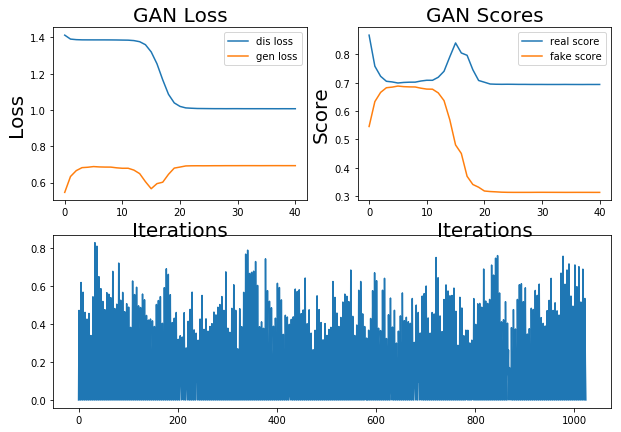

Epoch:  0, Iter: 40, d_loss: 1.00682509, g_loss:0.69291031


KeyboardInterrupt: 

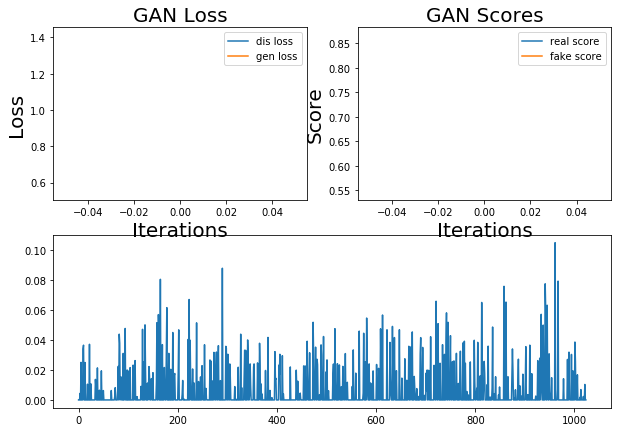

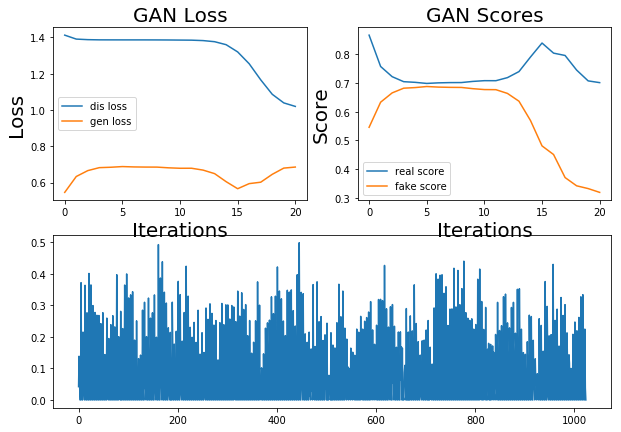

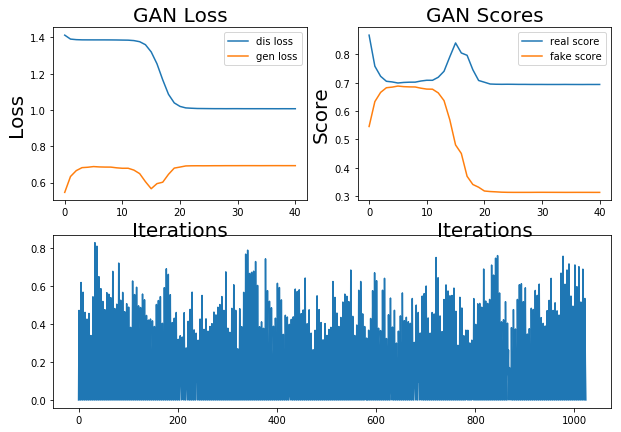

In [4]:
with tf.Session() as sess:
    model = dcgan(sess = sess, 
                  x_dim = x_data.shape[1], 
                  y_dim = sx_data.shape[1], 
                  x_data = x_data, 
                  y_data = sx_data, 
                  batch_size = 64, 
                  nepoch = 1, 
                  z_dim = 100, 
                  gf_dim = 16, 
                  df_dim = 16, 
                  lr = 1e-4)
    model.train()

In [8]:
np.random.choice(10,1)

array([9])